# Домашняя работа №3

При отправлении ДЗ в Dropbox указывайте фамилию в названии файла: <br\>
** IDA<Номер группы>HW3<Фамилия>.ipynb ** - например ** IDA3HW3Pupkin.ipynb **<br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="autoencoder.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy as np

import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.pkl*. Данный файл содержит набор фото. 

In [2]:
import pickle as pkl
import numpy as np

In [3]:
images = np.load(open('images.npy', 'br'))

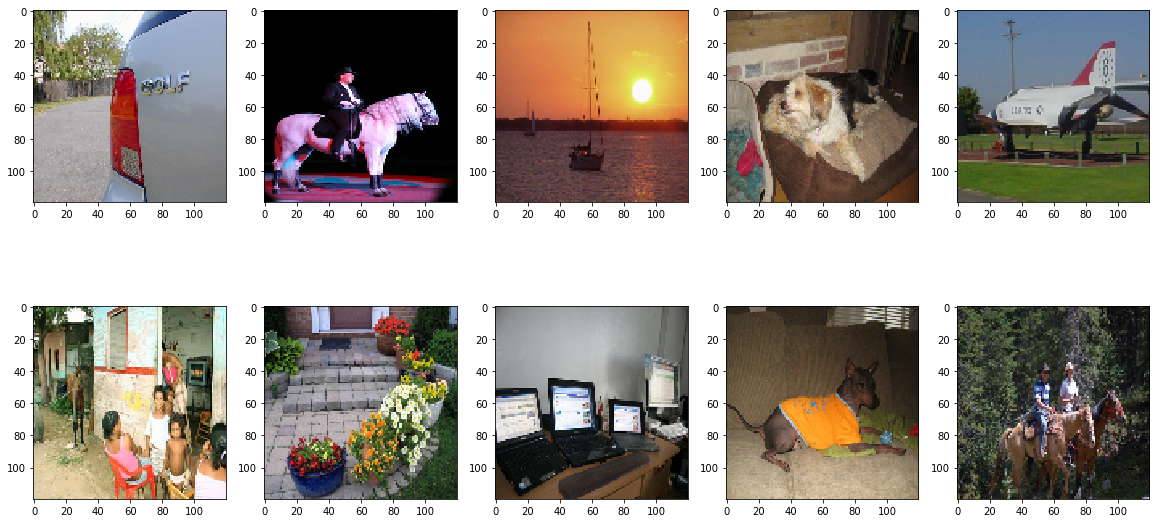

In [4]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [2]:
def get_patch(image,crop_shape=((0, 0), (0, 0))):
    return image[crop_shape[0][0]:crop_shape[0][1],crop_shape[1][0]:crop_shape[1][1],:]

In [3]:
def get_samples(full_images, num_samples=10000, sample_size=16, rand_state=123):
    # входные параметры
    # full_images: np.array, исходный датасет
    # num_samples: int, количество патчей, которые функция должна вернуть
    # sample_size: int, длина стороны каждого патча
    # rand_seed: int, число для инициализации np.random.seed, чтобы генерация датасета была воспроизводимой
    
    # выход функции
    # np.array размера [num_samples, sample_size, sample_size, 3]
    num_images = full_images.shape[0]-1
    H = full_images.shape[1]
    W = full_images.shape[2]
    data = np.empty(shape=(num_samples,sample_size,sample_size,3))
    r = np.random.RandomState(rand_state)
    i = 0
    while(i!=num_samples):
        j = i%num_images
        h = r.randint(0,H-1-sample_size)
        w = r.randint(0,W-1-sample_size)
        data[i] = get_patch(full_images[j],((h,h+sample_size),(w,w+sample_size)))
        i+=1
    return data

In [7]:
ds = get_samples(images,10000)

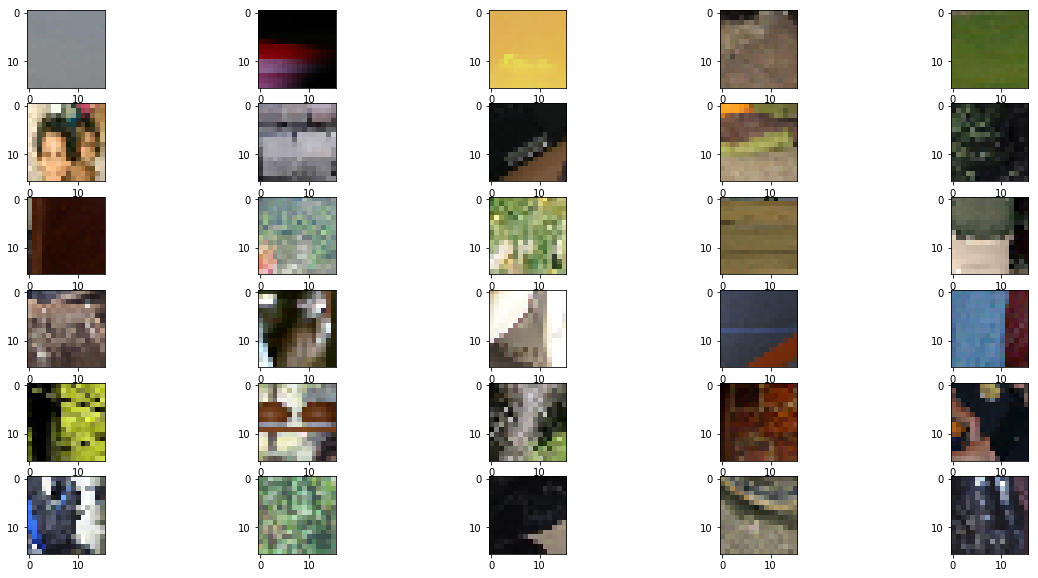

In [8]:
plt.figure(figsize=(20, 10))

for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.imshow(ds[i])

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [9]:
ds.max()

1.0

In [10]:
ds.min()

0.0

In [4]:
def rescale(inp_arr,a,b):
    arr = inp_arr.copy()
    arrmax = arr.max()
    arrmin = arr.min()
    arr = (arr - arrmin)*((b-a)/(arrmax - arrmin)) + a
    return arr

In [12]:
ds_sc = rescale(ds,0.1,0.9)

In [13]:
ds_sc.max()

0.90000000000000002

In [14]:
ds_sc.min()

0.10000000000000001

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [15]:
ds_sc.shape

(10000, 16, 16, 3)

In [16]:
ds_sc = ds_sc.reshape(10000,16*16*3)

In [17]:
ds_sc.shape

(10000, 768)

In [18]:
del images
del ds

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer

In [6]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400],learning_rate = 0.001):
    # входные параметры:
    # object_size: int, размер входного и выходного слоя автоэнкодера
    # encoder_layer_shapes: list of int, количество нейронов в каждом слое энкодера. 
    #                       последний элемент списка - размер "бутылочного горлышка"
    # decoder_layer_shapes: ist of int, количество нейронов в каждом слое декодера
    
    # выход:
    # keras модель
    model = Sequential()
    model.add(InputLayer(input_shape=(object_size,)))
    for i in encoder_layer_shapes:
        model.add(Dense(i,activation="relu"))
    for i in decoder_layer_shapes:
        model.add(Dense(i,activation="relu"))
    model.add(Dense(object_size,activation="sigmoid"))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr = learning_rate))
    return model

In [83]:
m1 = create_autoencoder_model()

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test = train_test_split(ds_sc, test_size = 0.1,random_state = 25)

Обучите модель со стандартными параметрами.

In [84]:
hist1 = m1.fit(x = X_train, y = X_train,batch_size=100,epochs=50,validation_data=(X_test, X_test),verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 3s - loss: 0.0309 - val_loss: 0.0127
Epoch 2/50
9000/9000 [==============================] - 3s - loss: 0.0122 - val_loss: 0.0115
Epoch 3/50
9000/9000 [==============================] - 3s - loss: 0.0112 - val_loss: 0.0103
Epoch 4/50
9000/9000 [==============================] - 2s - loss: 0.0100 - val_loss: 0.0094
Epoch 5/50
9000/9000 [==============================] - 2s - loss: 0.0095 - val_loss: 0.0091
Epoch 6/50
9000/9000 [==============================] - 2s - loss: 0.0091 - val_loss: 0.0086
Epoch 7/50
9000/9000 [==============================] - 2s - loss: 0.0086 - val_loss: 0.0081
Epoch 8/50
9000/9000 [==============================] - 2s - loss: 0.0083 - val_loss: 0.0079
Epoch 9/50
9000/9000 [==============================] - 2s - loss: 0.0080 - val_loss: 0.0077
Epoch 10/50
9000/9000 [==============================] - 2s - loss: 0.0078 - val_loss: 0.0074
Epoch 11/50
9000/9000

In [85]:
m1.evaluate(X_test,X_test)

 960/1000 [===========================>..] - ETA: 0s

0.005286265663802624

In [34]:
m1.save('task1.h5')

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

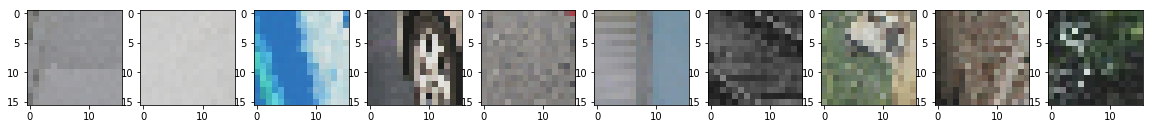

In [35]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_test[i].reshape(16,16,3))


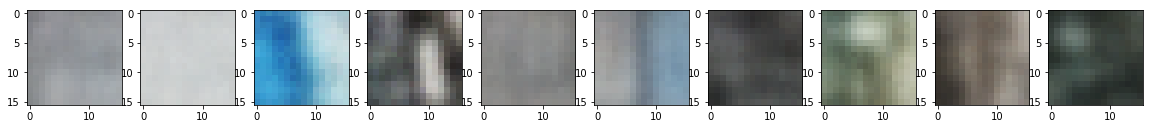

In [36]:
plt.figure(figsize=(20, 10))
Res1 = m1.predict(X_test[:10])
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(Res1[i].reshape(16,16,3))

## Модель учится восстанавливать изображения, но на параметрах по умолчанию результат получается довольно "размытым".

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

В задании имеются в виду слои энкодера.

In [37]:
max_act = np.array((np.zeros(256),np.zeros(144),np.zeros(64)))#максимальные активации
max_pic = np.array((np.zeros(256,dtype=int),np.zeros(144,dtype=int),np.zeros(64,dtype=int)))#индексы изображений на которых достигаются максимальыне активации

In [38]:
from keras import backend as K

In [39]:
def get_i_layer_output(i,m, arr):
    func = K.function([m.layers[0].input], [m.layers[i].output])
    return func([arr])[0]

In [43]:
for i in range(0,3):
    outputs = get_i_layer_output(i+1,m1,X_train)#+1 потому что в модели первым слоем стоит InputLayer
    for j in range(0,max_act[i].shape[0]):
        max_act[i][j] = outputs[:,j].max()
        max_pic[i][j] = outputs[:,j].argmax()

In [52]:
max_act[0]#для первого слоя из 256 нейронов

array([ 0.        ,  0.        ,  0.        ,  0.        ,  5.14048195,
        0.        ,  0.        ,  0.        ,  0.        ,  5.03455925,
        0.        ,  4.7954731 ,  1.60943675,  0.        ,  2.21612072,
        0.        ,  3.40334487,  1.63323021,  0.        ,  3.60247755,
        1.77957904,  2.83146405,  1.35699964,  0.        ,  0.        ,
        1.63856864,  0.        ,  2.7046237 ,  0.51271766,  0.        ,
        0.78495544,  4.51852226,  0.        ,  0.        ,  0.        ,
        3.44538188,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  4.22866249,  0.        ,  0.        ,
        6.13901758,  3.66640949,  3.85119843,  0.        ,  0.        ,
        2.55513668,  6.96856403,  2.94665289,  0.        ,  4.22583246,
        0.        ,  0.12460726,  1.06232679,  0.        ,  2.97471857,
        0.        ,  0.        ,  0.        ,  4.84668922,  2.49988866,
        3.27288747,  3.79624152,  0.70092618,  0.        ,  0.64

In [53]:
max_pic[0]#для первого слоя из 256 нейронов

array([   0,    0,    0,    0,  983,    0,    0,    0,    0, 3982,    0,
       6574, 4083,    0,  288,    0, 6899, 8552,    0, 2754, 3622, 5781,
       6119,    0,    0, 2809,    0, 8529, 4885,    0, 8740, 6266,    0,
          0,    0, 6273,    0,    0,    0,    0,    0,    0, 6273,    0,
          0, 5781, 3366, 4851,    0,    0, 5781, 3970, 3546,    0, 2602,
          0, 3483, 3219,    0, 8638,    0,    0,    0, 3599, 8379, 3546,
       1055, 2090,    0, 8518, 7278, 5426, 3112,    0,    0,    0,    0,
       8582, 4795,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       7154,    0, 5813, 5855,    0,    0,    0,    0,    0,    0,  549,
          0,    0,    0,    0,    0,    0, 5781,  587, 3366, 1585,    0,
          0,    0, 2512,    0, 3970,  127, 3366,    0,    0,    0,    0,
       2602,    0,    0,    0,    0,    0, 5649,    0, 7216, 8653, 6496,
          0,    0,    0, 4767,  549, 4937,    0,    0,    0, 5878,    0,
          0,    0,  235, 7216, 6244, 6266,    0, 76

In [56]:
l0 = max_pic[0][max_act[0]!=0]
l1 = max_pic[1][max_act[1]!=0]
l2 = max_pic[2][max_act[2]!=0]

In [63]:
l1.shape

(81,)

In [17]:
def print_imgs_grid(images, n_cols, n_rows):
    fig = plt.figure(figsize=(2*n_cols,2*n_rows))
    for i in range(0, images.shape[0] ):
        fig.add_subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])

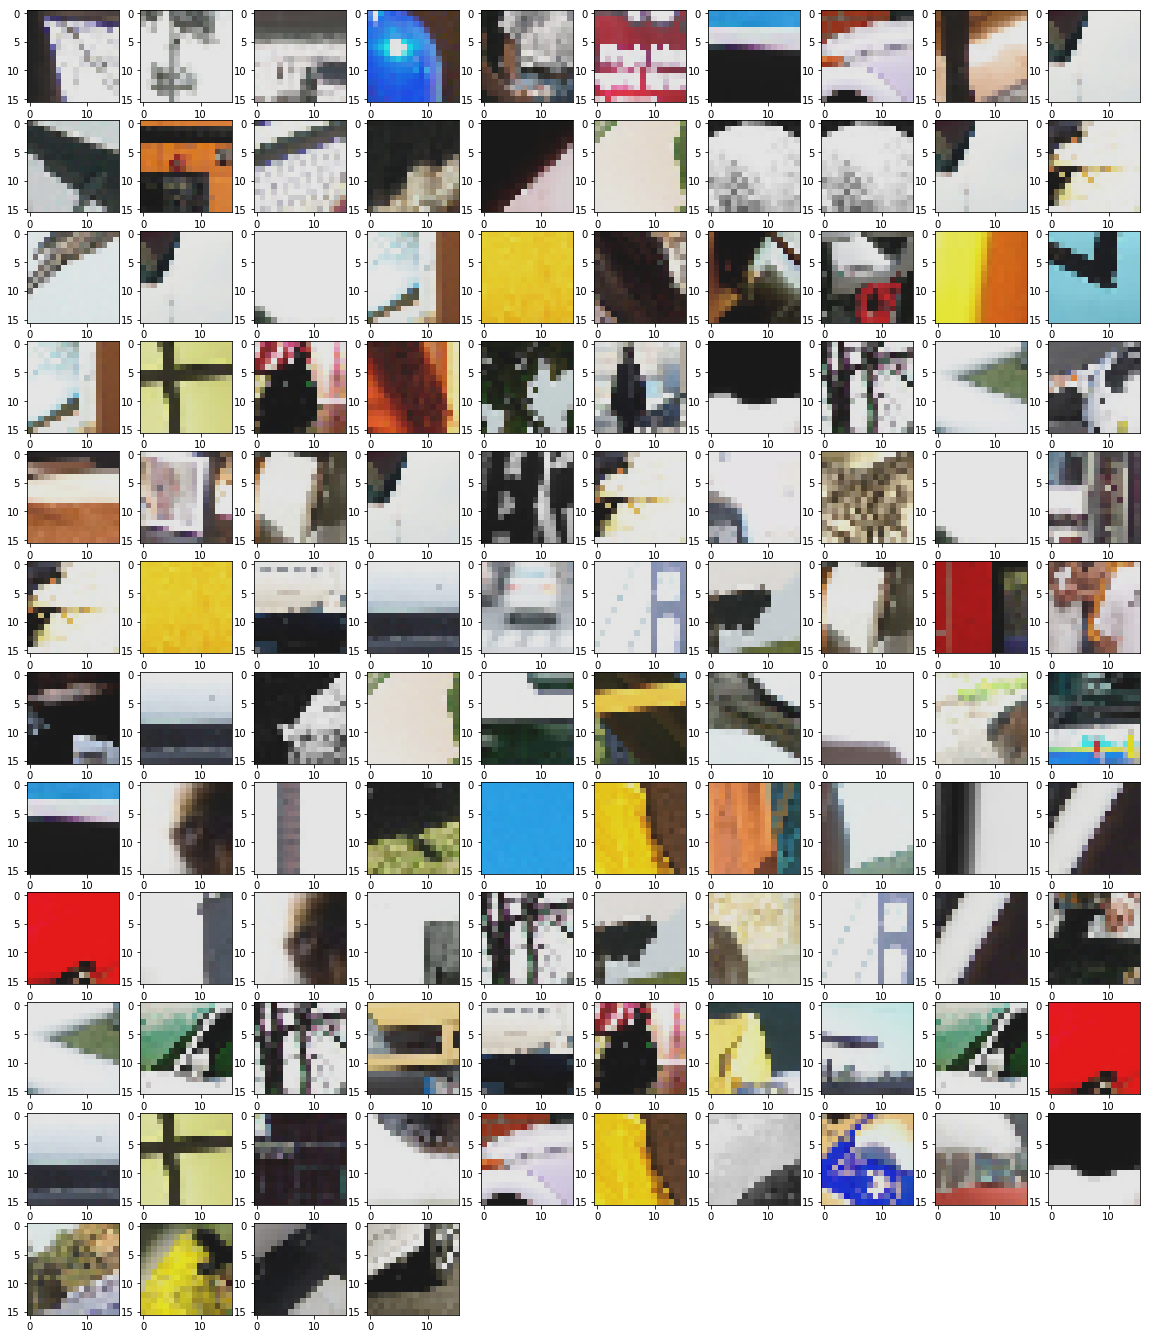

In [215]:
print_imgs_grid(X_train[l0].reshape(X_train[l0].shape[0],16,16,3),10,12)

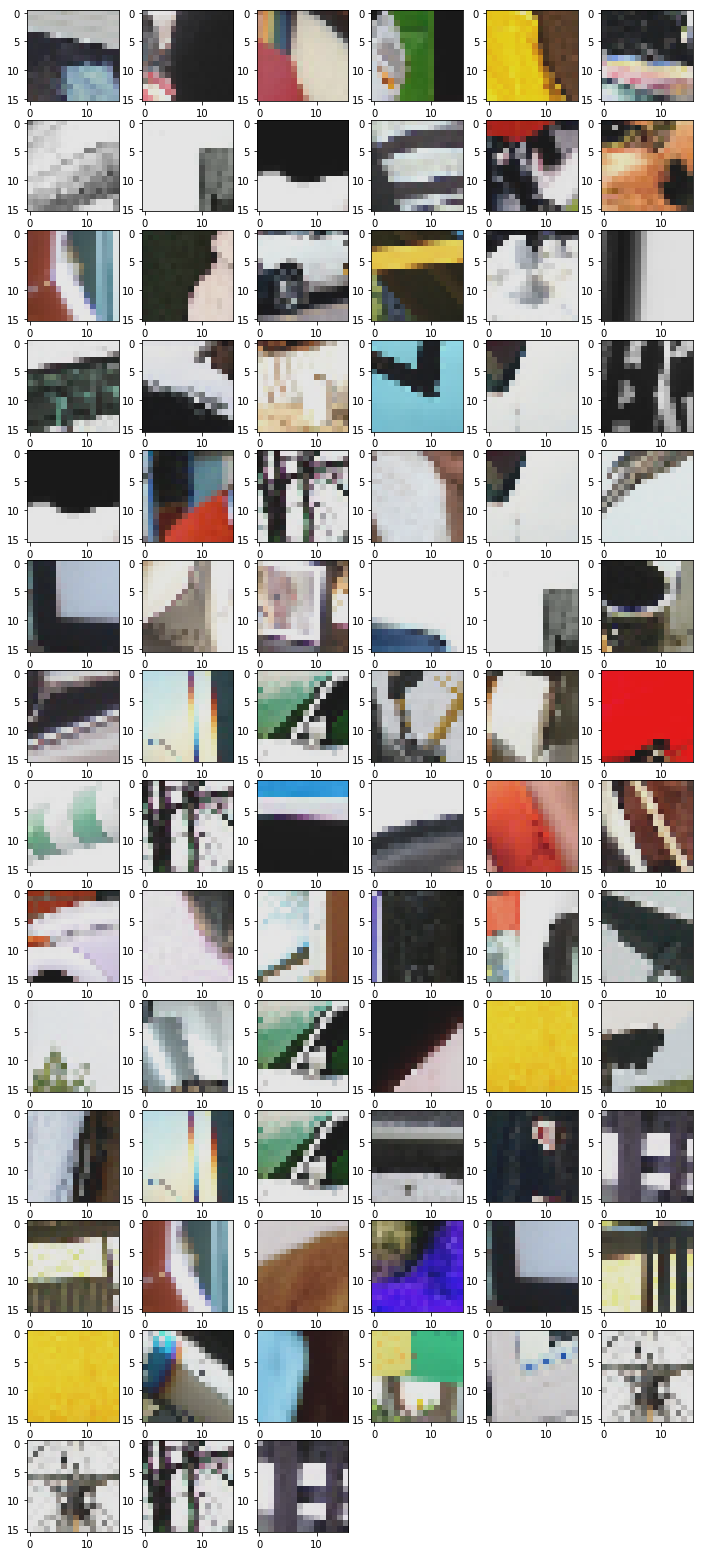

In [73]:
print_imgs_grid(X_train[l1].reshape(X_train[l1].shape[0],16,16,3),6,14)

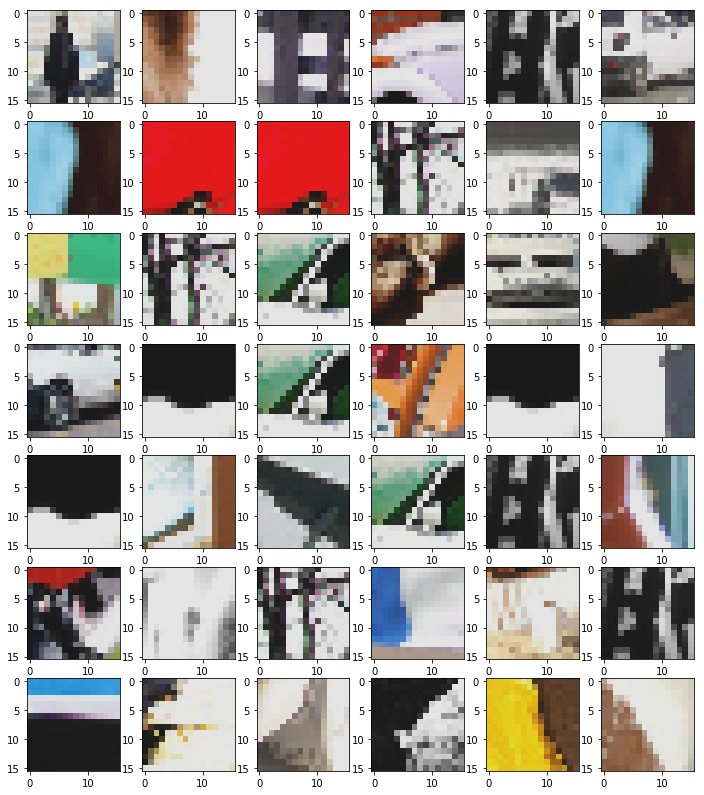

In [75]:
print_imgs_grid(X_train[l2].reshape(X_train[l2].shape[0],16,16,3),6,7)

In [206]:
np.intersect1d(l0,l2).shape

(15,)

In [207]:
l2.shape

(42,)

## Многие нейроны не активировались ни на одном  объекте

Это недостаток сети с полносвязными слоями, получается в модели много параметров, но по факту многие из них не используются.

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400]

In [86]:
m2 = create_autoencoder_model(encoder_layer_shapes=[654,456,328,250,120],decoder_layer_shapes=[250,380,480,690])

In [87]:
%%time
m2.fit(x = X_train, y = X_train,batch_size=100,epochs=50,validation_data=(X_test, X_test),verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 7s - loss: 0.0305 - val_loss: 0.0186
Epoch 2/50
9000/9000 [==============================] - 7s - loss: 0.0175 - val_loss: 0.0167
Epoch 3/50
9000/9000 [==============================] - 7s - loss: 0.0161 - val_loss: 0.0142
Epoch 4/50
9000/9000 [==============================] - 7s - loss: 0.0142 - val_loss: 0.0140
Epoch 5/50
9000/9000 [==============================] - 7s - loss: 0.0141 - val_loss: 0.0140
Epoch 6/50
9000/9000 [==============================] - 7s - loss: 0.0141 - val_loss: 0.0140
Epoch 7/50
9000/9000 [==============================] - 8s - loss: 0.0129 - val_loss: 0.0115
Epoch 8/50
9000/9000 [==============================] - 7s - loss: 0.0116 - val_loss: 0.0114
Epoch 9/50
9000/9000 [==============================] - 6s - loss: 0.0115 - val_loss: 0.0113
Epoch 10/50
9000/9000 [==============================] - 7s - loss: 0.0115 - val_loss: 0.0113
Epoch 11/50
9000/9000

In [92]:
m2.save('m2.h5')

* ## Модель m2 энкодер=[654,456,328,250,120], декодер=[250,380,480,690]
имеет больше слоев в энкодере и декодере чем модель с параметрами по умолчнаию и более широкий bottleneck.
Обучается дольше и сходится медленнее чем модель с параметрами по умолчнаию и имеет больший loss при том же числе эпох.

In [93]:
m3 = create_autoencoder_model(encoder_layer_shapes=[380,250,150,30],decoder_layer_shapes=[150,350,450])

In [94]:
%%time
m3.fit(x = X_train, y = X_train,batch_size=100,epochs=50,validation_data=(X_test, X_test),verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 3s - loss: 0.0306 - val_loss: 0.0165
Epoch 2/50
9000/9000 [==============================] - 3s - loss: 0.0140 - val_loss: 0.0119
Epoch 3/50
9000/9000 [==============================] - 3s - loss: 0.0118 - val_loss: 0.0114
Epoch 4/50
9000/9000 [==============================] - 3s - loss: 0.0115 - val_loss: 0.0107
Epoch 5/50
9000/9000 [==============================] - 4s - loss: 0.0108 - val_loss: 0.0105
Epoch 6/50
9000/9000 [==============================] - 3s - loss: 0.0105 - val_loss: 0.0100
Epoch 7/50
9000/9000 [==============================] - 3s - loss: 0.0101 - val_loss: 0.0099
Epoch 8/50
9000/9000 [==============================] - 3s - loss: 0.0101 - val_loss: 0.0099
Epoch 9/50
9000/9000 [==============================] - 3s - loss: 0.0100 - val_loss: 0.0097
Epoch 10/50
9000/9000 [==============================] - 3s - loss: 0.0096 - val_loss: 0.0090
Epoch 11/50
9000/9000

In [98]:
m3.save('m3.h5')

* ## Модель m3 энкодер=[380,250,150,30], декодер=[150,350,450]
также имеет больше слоев в энкодере и декодере чем модель с параметрами по умолчанию, но имеет более узкий bottleneck.
сходится медленнее чем модель с параметрами по умолчнаию и имеет больший loss при том же числе эпох. Однако, лучше чем модель m2

In [96]:
m4 = create_autoencoder_model(encoder_layer_shapes=[450,250],decoder_layer_shapes=[378,568])

In [97]:
%%time
m4.fit(x = X_train, y = X_train,batch_size=100,epochs=50,validation_data=(X_test, X_test),verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 4s - loss: 0.0310 - val_loss: 0.0140
Epoch 2/50
9000/9000 [==============================] - 4s - loss: 0.0115 - val_loss: 0.0103
Epoch 3/50
9000/9000 [==============================] - 3s - loss: 0.0099 - val_loss: 0.0090
Epoch 4/50
9000/9000 [==============================] - 4s - loss: 0.0089 - val_loss: 0.0082
Epoch 5/50
9000/9000 [==============================] - 5s - loss: 0.0082 - val_loss: 0.0076
Epoch 6/50
9000/9000 [==============================] - 4s - loss: 0.0076 - val_loss: 0.0074
Epoch 7/50
9000/9000 [==============================] - 4s - loss: 0.0073 - val_loss: 0.0070
Epoch 8/50
9000/9000 [==============================] - 4s - loss: 0.0070 - val_loss: 0.0065
Epoch 9/50
9000/9000 [==============================] - 4s - loss: 0.0066 - val_loss: 0.0067
Epoch 10/50
9000/9000 [==============================] - 4s - loss: 0.0064 - val_loss: 0.0059
Epoch 11/50
9000/9000

In [100]:
m4.save('m4.h5')

* ## Модель m4 энкодер=[450,250], декодер=[378,568]
имеет меньше слоев в энкодере чем модель по умолчанию, но имеет более широкий bottleneck. Сходится быстрее и имеет loss меньше чем все модели выше.

In [102]:
m5= create_autoencoder_model(encoder_layer_shapes=[350, 30],decoder_layer_shapes=[250,378])

In [103]:
%%time
m5.fit(x = X_train, y = X_train,batch_size=100,epochs=50,validation_data=(X_test, X_test),verbose=1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 3s - loss: 0.0336 - val_loss: 0.0156
Epoch 2/50
9000/9000 [==============================] - 2s - loss: 0.0135 - val_loss: 0.0117
Epoch 3/50
9000/9000 [==============================] - 2s - loss: 0.0117 - val_loss: 0.0114
Epoch 4/50
9000/9000 [==============================] - 2s - loss: 0.0110 - val_loss: 0.0105
Epoch 5/50
9000/9000 [==============================] - 2s - loss: 0.0104 - val_loss: 0.0100
Epoch 6/50
9000/9000 [==============================] - 2s - loss: 0.0102 - val_loss: 0.0098
Epoch 7/50
9000/9000 [==============================] - 2s - loss: 0.0098 - val_loss: 0.0094
Epoch 8/50
9000/9000 [==============================] - 2s - loss: 0.0095 - val_loss: 0.0093
Epoch 9/50
9000/9000 [==============================] - 2s - loss: 0.0096 - val_loss: 0.0092
Epoch 10/50
9000/9000 [==============================] - 2s - loss: 0.0094 - val_loss: 0.0092
Epoch 11/50
9000/9000

* ## Модель m5 энкодер = [350,30] декодер = [250,378]
Имеет меньше слоев чем модель по умолчнию и более узкий bottleneck. Имеет самый большой loss.

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [105]:
del ds_sc

In [7]:
from keras.datasets import mnist

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
x_train.shape

(60000, 28, 28)

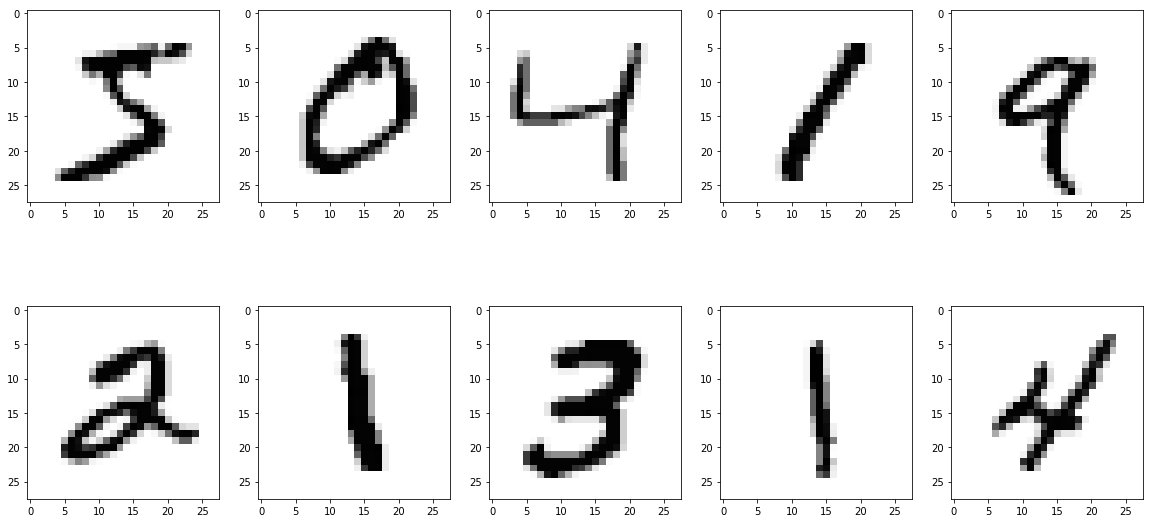

In [10]:
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i],cmap="Greys")

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [11]:
model = create_autoencoder_model(encoder_layer_shapes=[30],decoder_layer_shapes=[],object_size=28*28)

In [14]:
x_train_res = rescale(x_train.reshape(x_train.shape[0],28*28),0,1)
x_test_res = rescale(x_test.reshape(x_test.shape[0],28*28),0,1)

In [15]:
model.fit(x = x_train_res, y = x_train_res,batch_size=350,epochs=100,validation_data=(x_test_res, x_test_res),verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s - loss: 0.0803 - val_loss: 0.0498
Epoch 2/100
60000/60000 [==============================] - 2s - loss: 0.0418 - val_loss: 0.0351
Epoch 3/100
60000/60000 [==============================] - 2s - loss: 0.0318 - val_loss: 0.0280
Epoch 4/100
60000/60000 [==============================] - 2s - loss: 0.0261 - val_loss: 0.0235
Epoch 5/100
60000/60000 [==============================] - 2s - loss: 0.0224 - val_loss: 0.0205
Epoch 6/100
60000/60000 [==============================] - 2s - loss: 0.0198 - val_loss: 0.0183
Epoch 7/100
60000/60000 [==============================] - 3s - loss: 0.0178 - val_loss: 0.0166
Epoch 8/100
60000/60000 [==============================] - 3s - loss: 0.0163 - val_loss: 0.0154
Epoch 9/100
60000/60000 [==============================] - 3s - loss: 0.0152 - val_loss: 0.0144
Epoch 10/100
60000/60000 [==============================] - 3s - loss: 0.0143 - val_lo

### Изображение прошедшее через автоэнкодер:

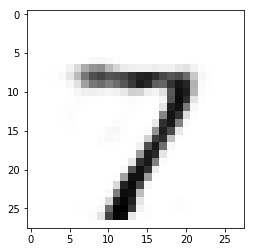

In [16]:
plt.imshow(model.predict(x_test_res[:1]).reshape(28,28),cmap="Greys")

### Оригинальное изображение:

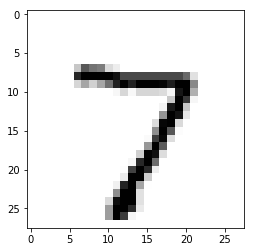

In [17]:
plt.imshow(x_test_res[0].reshape(28,28),cmap="Greys")

In [27]:
enc_x_train = get_i_layer_output(1,model,x_train_res)
enc_x_test = get_i_layer_output(1,model,x_test_res)

In [19]:
enc_x_train.shape

(60000, 30)

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [37]:
svc  = SVC(cache_size=500)

In [38]:
%%time
svc.fit(enc_x_train,y_train)

CPU times: user 17min 4s, sys: 10.3 s, total: 17min 14s
Wall time: 17min 14s


SVC(C=1.0, cache_size=500, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Качество SVM:

In [39]:
accuracy_score(svc.predict(enc_x_test),y_test)

0.81779999999999997

In [41]:
knn = KNeighborsClassifier()

In [42]:
knn.fit(enc_x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## Качество KNN:

In [43]:
accuracy_score(knn.predict(enc_x_test),y_test)

0.9677

In [44]:
rfc = RandomForestClassifier()

In [45]:
rfc.fit(enc_x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Качество Random Forest:

In [46]:
accuracy_score(rfc.predict(enc_x_test),y_test)

0.9103

In [47]:
gbc = GradientBoostingClassifier()

In [48]:
gbc.fit(enc_x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

## Качество Gradient Boosting:

In [49]:
accuracy_score(gbc.predict(enc_x_test),y_test)

0.90939999999999999

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [8]:
from keras.datasets import cifar10

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [10]:
x_train.shape

(50000, 32, 32, 3)

In [11]:
train_samples = get_samples(x_train,50000,sample_size=8)

In [12]:
train_samples = rescale(train_samples.reshape(50000,8*8*3),0,1)

In [13]:
model_cif = create_autoencoder_model(encoder_layer_shapes=[30],decoder_layer_shapes=[],object_size=8*8*3)

In [14]:
model_cif.fit(x = train_samples, y = train_samples,batch_size=1000,epochs=100,verbose=1)

Epoch 1/100
50000/50000 [==============================] - 1s - loss: 0.0581     
Epoch 2/100
50000/50000 [==============================] - 0s - loss: 0.0425     
Epoch 3/100
50000/50000 [==============================] - 0s - loss: 0.0311     
Epoch 4/100
50000/50000 [==============================] - 0s - loss: 0.0247     
Epoch 5/100
50000/50000 [==============================] - 0s - loss: 0.0192     
Epoch 6/100
50000/50000 [==============================] - 0s - loss: 0.0146     
Epoch 7/100
50000/50000 [==============================] - 0s - loss: 0.0111     
Epoch 8/100
50000/50000 [==============================] - 0s - loss: 0.0090     
Epoch 9/100
50000/50000 [==============================] - 0s - loss: 0.0078     
Epoch 10/100
50000/50000 [==============================] - 0s - loss: 0.0071     
Epoch 11/100
50000/50000 [==============================] - 0s - loss: 0.0065     
Epoch 12/100
50000/50000 [==============================] - 0s - loss: 0.0061     
Epoch 13/100


In [179]:
model_cif.save('model_cif.h5')

Теперь разделите каждую картинку из датасета на 16 сэмплjd размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 480 признаками

In [15]:
def img_to_16s(img):
    pic = list()
    for i in np.arange(0,32,8):
        for j in np.arange(0,32,8):
            #print((i,i+8),(j,j+8))
            pic.append(get_patch(img,((i,i+8),(j,j+8)))) 
    out = np.array(pic).reshape(16,8*8*3)
    return out

In [16]:
def ds_to_s(imgs):
    sampled_imgs = list()
    for i in imgs:
        sampled_imgs.append(img_to_16s(i))
    return np.array(sampled_imgs)

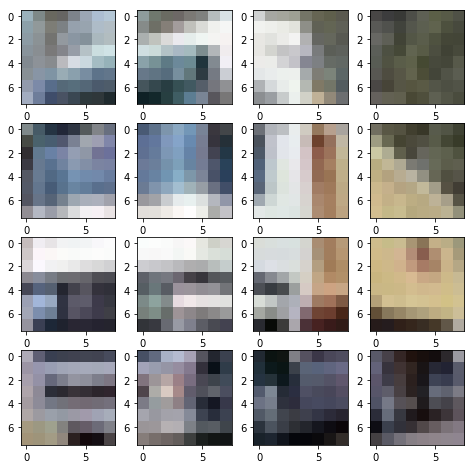

In [19]:
print_imgs_grid(img_to_16s(x_train[1]).reshape(16,8,8,3),4,4)

In [20]:

x_train_sc = rescale(x_train,0,1)
x_test_sc = rescale(x_test,0,1)

In [23]:
sampled_x_train = ds_to_s(x_train_sc)
sampled_x_test = ds_to_s(x_test_sc)

In [24]:
sampled_x_train.shape

(50000, 16, 192)

In [27]:
def encode_imgs(images):
    enc_imgs = list()
    out = keras.models.Model(model_cif.input,model_cif.layers[1].output)
    for i in images:
        enc_imgs.append(out.predict(i).reshape(16*30))
    return np.array(enc_imgs)

In [28]:
enc_x_train = encode_imgs(sampled_x_train)

In [29]:
enc_x_test = encode_imgs(sampled_x_test)

Теперь обучите SVM на преобразованных объектах и выведите точность.

In [31]:
svc_cif = SVC()

In [40]:
%%time
svc_cif.fit(enc_x_train,y_train)#rbf

/home/alex/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 39min 50s, sys: 76 ms, total: 39min 50s
Wall time: 39min 50s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
y_pred = svc_cif.predict(enc_x_test)

In [42]:
accuracy_score(y_pred,y_test)

0.49619999999999997